# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before.

But how do you own data into PyTorch?

One of the ways to do so is via: custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

## 0. Importing PyTorch and setting up device-agnostic code

In [2]:
import torch
from torch import nn

torch.__version__

'2.3.0+cu121'

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images. (~75 training, 25 testing)

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [4]:
import requests
import zipfile
# Saving our PyTorch model
from pathlib import Path

# 1. Create model directory
data_PATH = Path("data/")
image_path=data_PATH /"pizza_steak_sushi"
# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)


# Download
with open(data_PATH / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip
with zipfile.ZipFile(data_PATH / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [5]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.1 VIsualizing an image



data/pizza_steak_sushi/train/sushi/1221830.jpg
sushi
Random image path: data/pizza_steak_sushi/train/sushi/1221830.jpg
Random image class: sushi
Random image height: 512
Random image width: 512


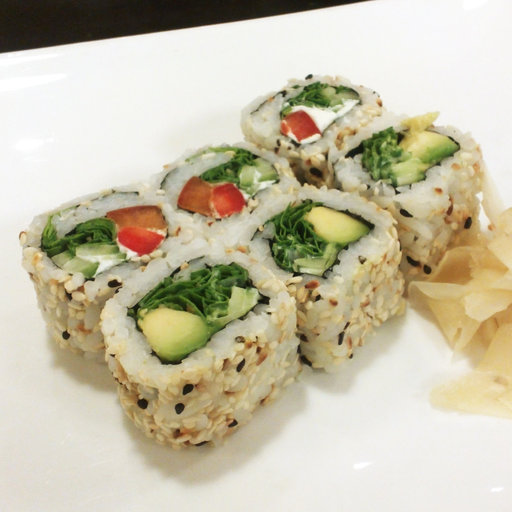

In [8]:
import random
from PIL import Image
# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Random image class: {image_class}")
print(f"Random image height: {img.height}")
print(f"Random image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

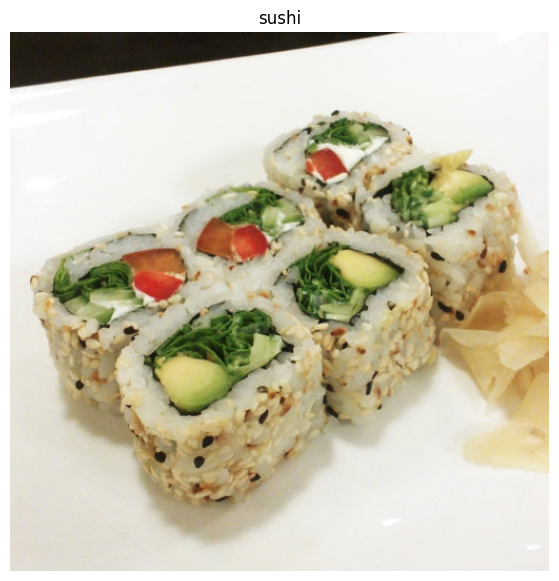

In [9]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"{image_class}")
plt.axis(False)

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical represenation of our images).
2. Turn it into a `torch.utils.data.dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation

In [11]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # Not acctually required
    # Turn the image into a torch.tensor
    transforms.ToTensor()
])

In [12]:
data_transform(img)

tensor([[[0.1333, 0.1373, 0.1373,  ..., 0.9765, 0.9765, 0.9725],
         [0.1333, 0.1255, 0.1294,  ..., 0.9765, 0.9765, 0.9725],
         [0.1294, 0.1255, 0.1255,  ..., 0.9765, 0.9725, 0.9725],
         ...,
         [0.8863, 0.8784, 0.8824,  ..., 0.9529, 0.9529, 0.9412],
         [0.8863, 0.8863, 0.8863,  ..., 0.9373, 0.9412, 0.9373],
         [0.8863, 0.8902, 0.8824,  ..., 0.9373, 0.9373, 0.9373]],

        [[0.1176, 0.1137, 0.1137,  ..., 0.9765, 0.9725, 0.9686],
         [0.1137, 0.1098, 0.1059,  ..., 0.9765, 0.9686, 0.9647],
         [0.1098, 0.1098, 0.1059,  ..., 0.9686, 0.9686, 0.9686],
         ...,
         [0.8627, 0.8588, 0.8549,  ..., 0.9412, 0.9451, 0.9294],
         [0.8627, 0.8627, 0.8627,  ..., 0.9255, 0.9255, 0.9255],
         [0.8667, 0.8667, 0.8667,  ..., 0.9255, 0.9216, 0.9176]],

        [[0.0784, 0.0784, 0.0863,  ..., 0.9686, 0.9686, 0.9608],
         [0.0706, 0.0627, 0.0706,  ..., 0.9725, 0.9686, 0.9608],
         [0.0745, 0.0745, 0.0706,  ..., 0.9686, 0.9608, 0.

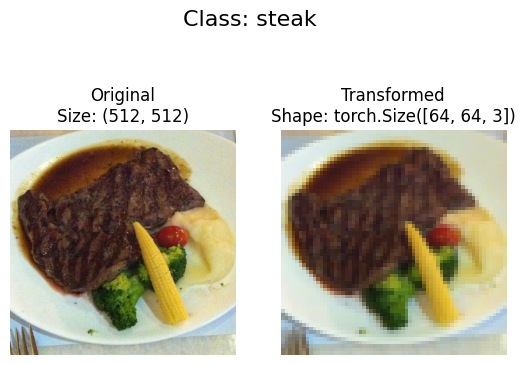

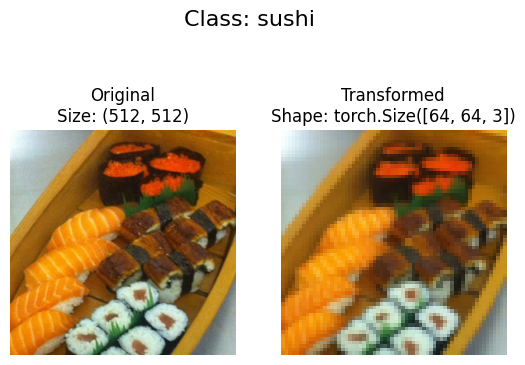

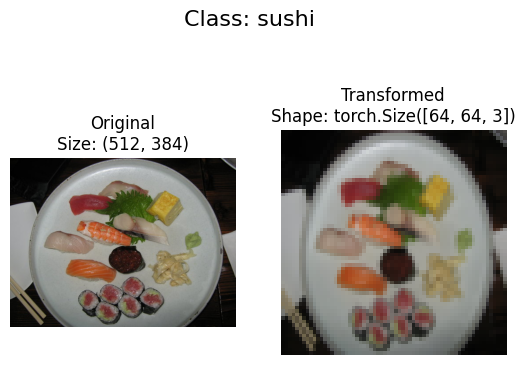

In [13]:
def plot_transformed_images(image_paths, transforms, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transforms(f).permute(1,2,0) # note we will need to change shape for matplotlib (C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transforms=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [14]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get class names as list
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# GEt class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the lengths of our datasets
len(train_data), len(test_data)

(225, 75)

In [18]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [19]:
# Index on the train data Dataset to get a single image and label
img, label=train_data[0][0],train_data[0][1]
img, img.shape, img.dtype, label, type(label)

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [20]:
label

0

In [21]:
class_names[label]

'pizza'

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Original shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

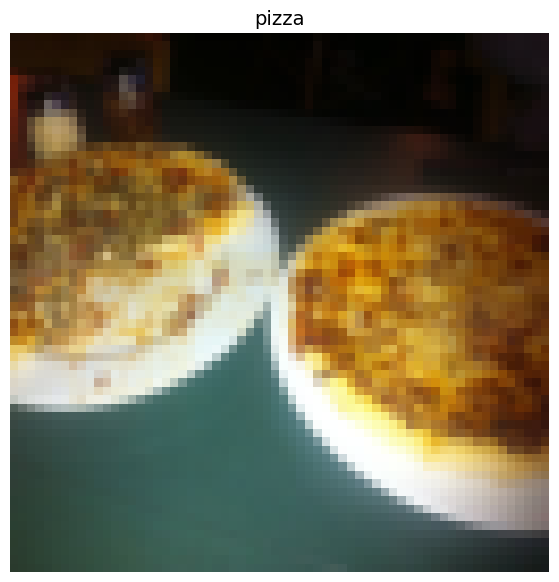

In [22]:
img_permute = img.permute(1,2,0)

print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Original shape: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

## 4.1 Turn Loaded images into `DataLoader's`

A `DataLoader` is going to help us turn turn our `Dataset`'s into iterables and we can customize the `batch_size` so our model can see batch_size images at a time.

In [23]:
import os
os.cpu_count()

2

In [24]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d6848c97f40>,
 <torch.utils.data.dataloader.DataLoader at 0x7d6848c95000>)

In [25]:
img, label = next(iter(train_dataloader))
# Batch size will now be 1, you can change the batch size if you like
img.shape, label.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though could create Dataset out of almost anything, it doesn't mean it will work...
* Using a custom Dataset often results in us writing more code, which could be prone to errors of performance issues

In [26]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [27]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [28]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [29]:
list(os.scandir(target_directory))

[<DirEntry 'sushi'>, <DirEntry 'pizza'>, <DirEntry 'steak'>]

In [30]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
  """Finds the class folder namees in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a directory of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes,  class_to_idx

In [31]:
class_names, class_to_idx=find_classes(target_directory)
class_names, class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To Create our own dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like transform our data.
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx -  a dict of the target classes mapped to integer labels

4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of our dataset
6. Overwrite the `__getitem__()` method to return a given sample when passed an index

In [32]:
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class atributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index:int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Return the total number of samples."
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Return one sample of data, data and label (X,y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # retrun data, label (X,y)
    else:
      return img, class_idx # return untransformed image and label

In [33]:
img, label = train_data[0]

In [34]:
img, label

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [35]:
# Create a trnasform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [36]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

In [37]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7d6848c45750>,
 <__main__.ImageFolderCustom at 0x7d6848c47430>)

In [38]:
len(train_data),len(train_data_custom)

(225, 225)

In [39]:
len(test_data),len(test_data_custom)

(75, 75)

In [40]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [41]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [42]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


Congratulations we have replicated the main functionality of the ImageFolder Dataset class

### 5.3 Create a function to dispaly random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.

2. To prevent the display getting out of hand, let's cap the number of images to see at 10.

3. Set the random seed for reproducibility.

4. Get a list of random sample indexes fro the target dataset.

5. Setup a matplotlib plot.

6. Loop through the random sample images and plot them with matplotlib.

7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [43]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10, # no. of images to display
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purpose, n shouldn't be larger than 10, setting to 10 and removing shape display.")


  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1,2,0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1,n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

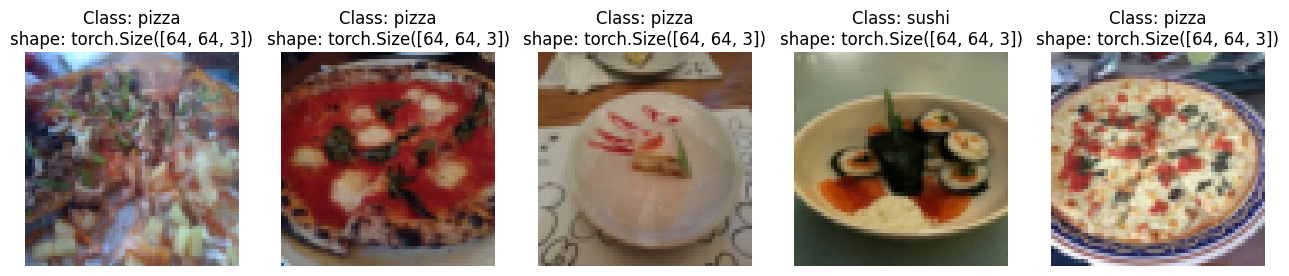

In [44]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

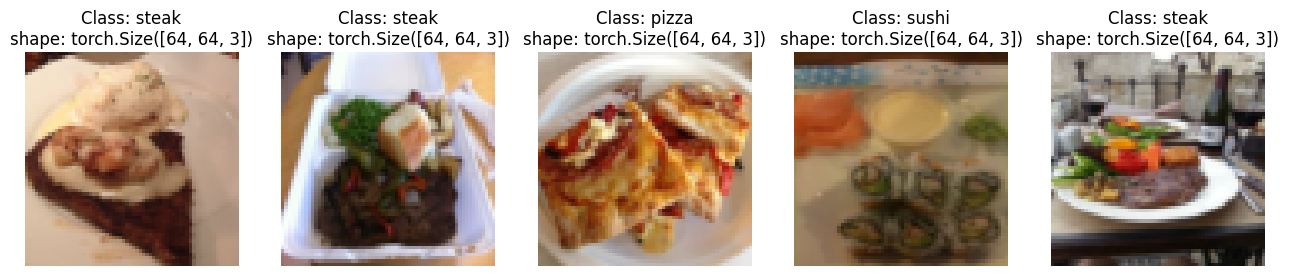

In [45]:
# Display random images from the ImageFolderCustom created Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `Dataloader`'s

In [46]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers = NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers = os.cpu_count(),
                                     shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7d6846af2bf0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d6846af3be0>)

In [47]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to  unseen data.

In [48]:
# Let's look at trivailaugment
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [49]:
image_path

PosixPath('data/pizza_steak_sushi')

In [50]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

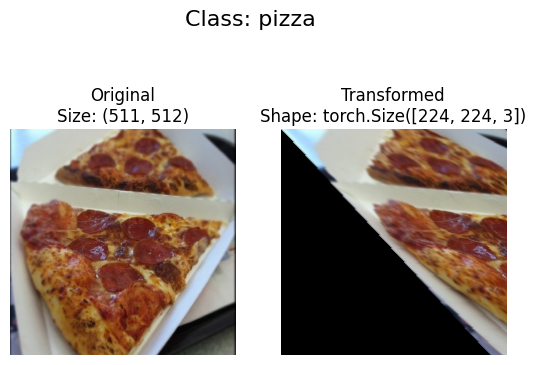

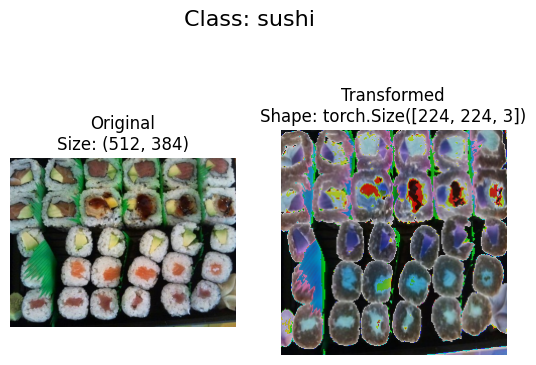

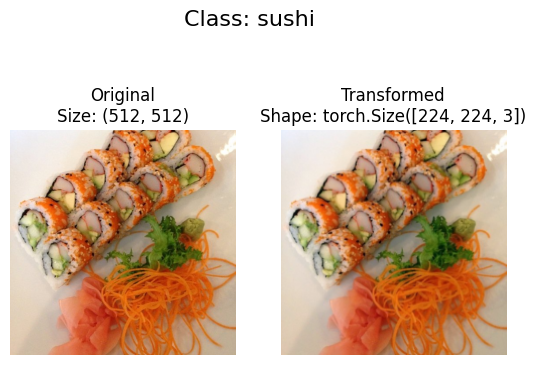

In [51]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transforms=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 creating transforms and loading data for Model 0

In [52]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [53]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=simple_transform)

import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle=True,
                                    num_workers =  NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle=False,
                                    num_workers =  NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [54]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*169,
                  out_features=output_shape)
    )

  def forward(self, x):
    x=self.classifier(self.conv_block_2(self.conv_block_1(x)))
    return x

In [55]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [56]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [57]:
# Try a forward Pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [58]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

In [59]:
from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Create train and test loops functions

* `train_step()` - take in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on dataloader.

In [60]:
 # Create train_step()
 def train_step(model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                device=device):
  # Put the model in trian mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0,0

  # Loop through data loader data batches
  for batch, (X,y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [61]:
 # Create train_step()
 def test_step(model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                device=device):
  # Put the model in eval mode
  model.eval()

  # Setup train loss and train accuracy values
  test_loss, test_acc = 0,0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X,y) in enumerate(dataloader):
      X,y = X.to(device), y.to(device)

      # 1. Forward Pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels==y).sum().item()/len(test_pred_labels)

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [62]:
# Measure time
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loss through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss: .4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss: .4f} | Test acc: {test_acc: .4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the end of the epochs
  return results

### 7.7 Train and evaluate model 0

In [63]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results= train(model= model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss:  1.1063 | Train acc: 0.3047 | Test loss:  1.0983 | Test acc:  0.3011
Epoch: 1 | Train loss:  1.0998 | Train acc: 0.3281 | Test loss:  1.0697 | Test acc:  0.5417
Epoch: 2 | Train loss:  1.0869 | Train acc: 0.4883 | Test loss:  1.0808 | Test acc:  0.4924
Epoch: 3 | Train loss:  1.0842 | Train acc: 0.3984 | Test loss:  1.0608 | Test acc:  0.5833
Epoch: 4 | Train loss:  1.0662 | Train acc: 0.4141 | Test loss:  1.0654 | Test acc:  0.5644
Total training time: 10.325 seconds


In [64]:
model_0_results

{'train_loss': [1.106319084763527,
  1.0998057276010513,
  1.0868544578552246,
  1.0842333137989044,
  1.0662163347005844],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.3984375, 0.4140625],
 'test_loss': [1.0983205238978069,
  1.069690187772115,
  1.0807572205861409,
  1.0608317852020264,
  1.065395991007487],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

### 7.8 Plot the loss curve of model_0

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [65]:

def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15,7))

  # Plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.grid()
  plt.legend()

  # Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.grid()
  plt.legend()

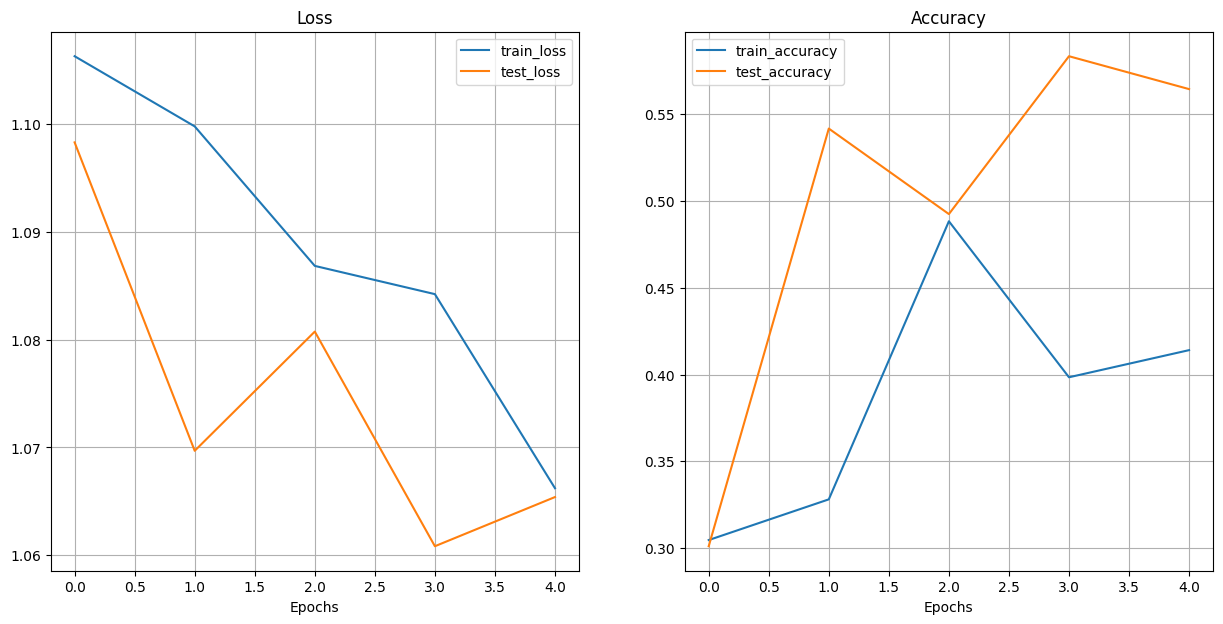

In [66]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?
https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A loss curve is one of the most helpful ways to troubleshoot a model.

## 9. Model 1: TinyVGG with Data Augmentation
( this is the way to deal with overfitting but are not overfitting at present)

Now let's try another modelling experiment this time using the same model as before with some data augmentation.

### 9.1 Create transform with data augmentation

In [67]:
# Create training  transform with TrivialAugmentation
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`'s and `Dataloader`'s with data augmentation

In [68]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                            transform=test_transform_simple)

In [69]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)

### 9.3 Construct and train model 1

This time using the same model architecture with augmented training and testing data.

In [70]:
# Model 1
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [71]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results= train(model= model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss:  1.1049 | Train acc: 0.2500 | Test loss:  1.1019 | Test acc:  0.2604
Epoch: 1 | Train loss:  1.0807 | Train acc: 0.4258 | Test loss:  1.1261 | Test acc:  0.2604
Epoch: 2 | Train loss:  1.0712 | Train acc: 0.4258 | Test loss:  1.1593 | Test acc:  0.2604
Epoch: 3 | Train loss:  1.1253 | Train acc: 0.3047 | Test loss:  1.1581 | Test acc:  0.2604
Epoch: 4 | Train loss:  1.0865 | Train acc: 0.4258 | Test loss:  1.1554 | Test acc:  0.3333
Total training time: 11.278 seconds


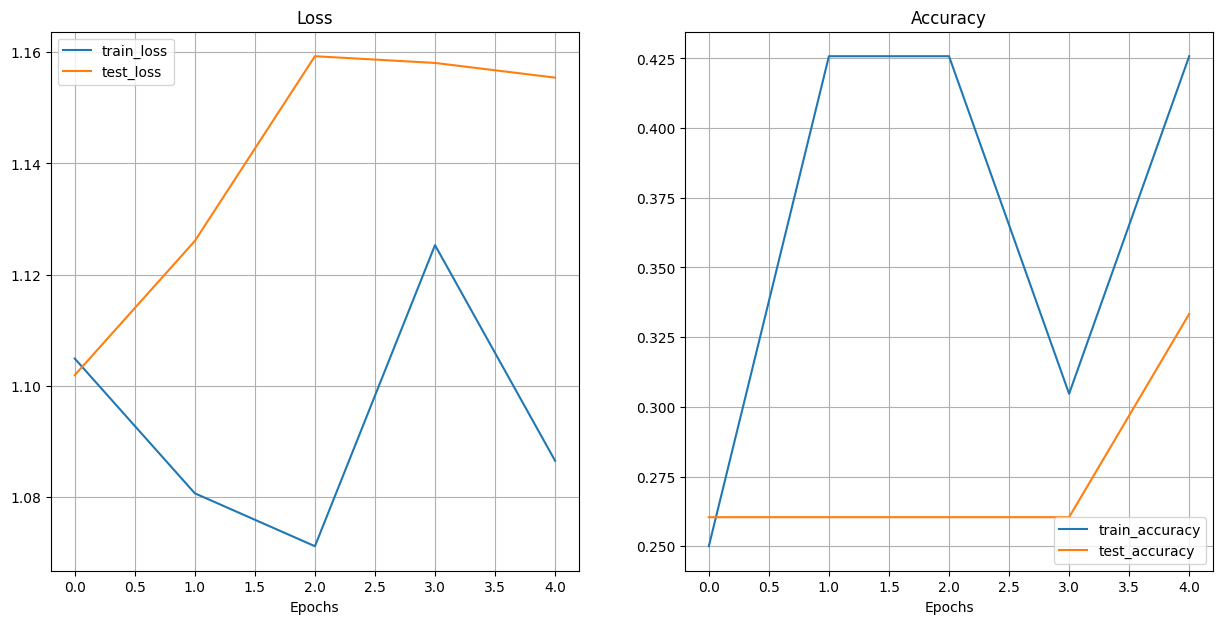

In [72]:
plot_loss_curves(model_1_results)

## 10. Compare model results

1. Hard Coding( what we are doing)
2. PyTorch + Tensorboard
3. Weights and Biases
4. MLFlow

In [73]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099806,0.328125,1.069690,0.541667
2,1.086854,0.488281,1.080757,0.492424
3,1.084233,0.398438,1.060832,0.583333
4,1.066216,0.414062,1.065396,0.564394


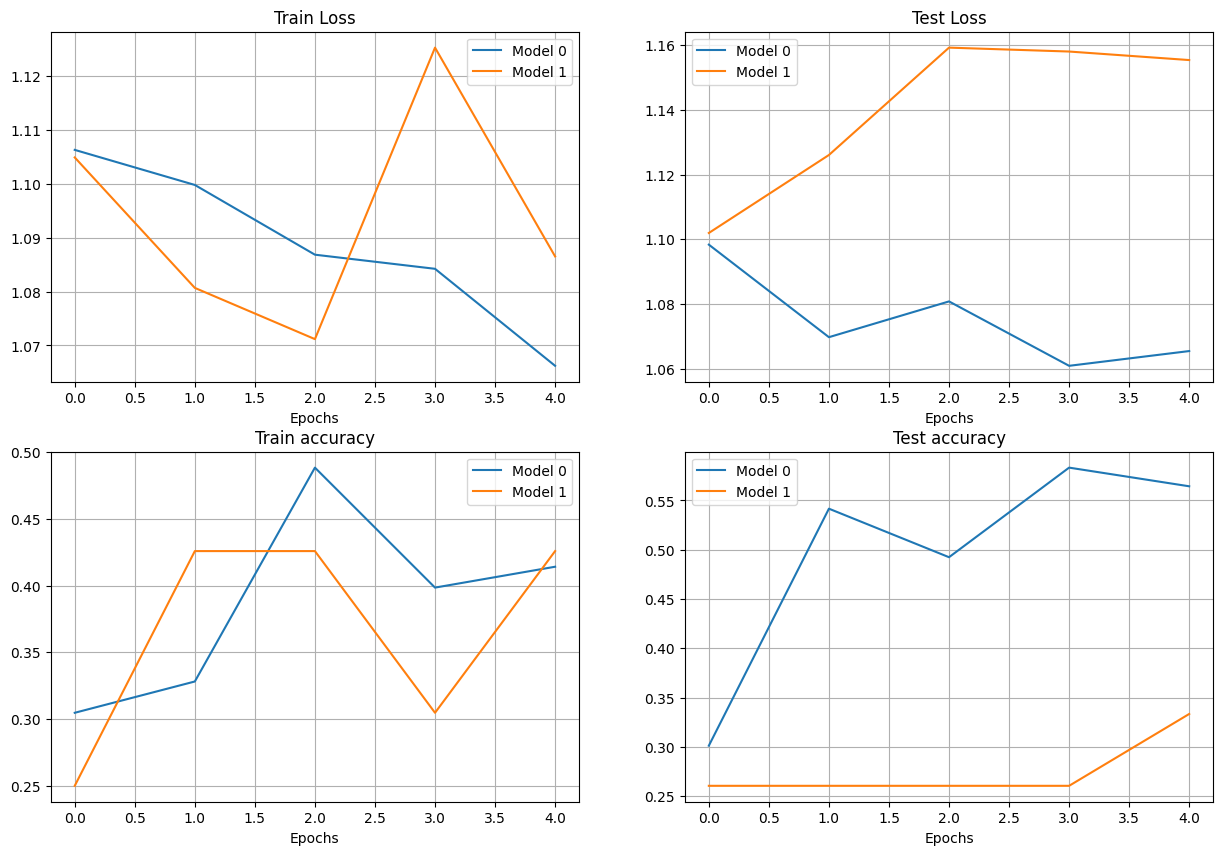

In [74]:
# Figure out how many epochs there were
epochs = range(len(model_0_df))

# Setup a plot
plt.figure(figsize=(15,10))

# Plot the train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"],label="Model 0")
plt.plot(epochs, model_1_df["train_loss"],label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.grid()
plt.legend()

# Plot the test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"],label="Model 0")
plt.plot(epochs, model_1_df["test_loss"],label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.grid()
plt.legend()

# Plot the train accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"],label="Model 0")
plt.plot(epochs, model_1_df["train_acc"],label="Model 1")
plt.title("Train accuracy")
plt.xlabel("Epochs")
plt.grid()
plt.legend()

# Plot the test accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"],label="Model 0")
plt.plot(epochs, model_1_df["test_acc"],label="Model 1")
plt.title("Test accuracy")
plt.xlabel("Epochs")
plt.grid()
plt.legend()

 ## 11. Making a prediction on a custom image
 Altough we've trained a model on custom data... how do you make a prediction on a sample/image that's not in either training or testing dataset

In [75]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_PATH / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device

We can read image in PyTorch using-
https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html

In [84]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(custom_image_path)
# a=torch.zeros(size=(4032,3024))
# custom_image_uint8[2]=a
custom_image_uint8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

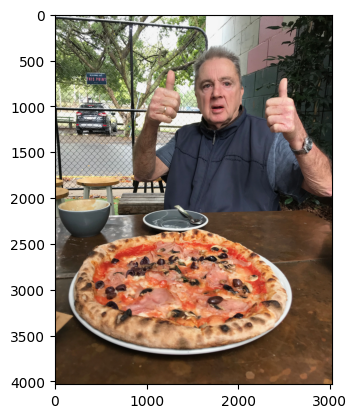

In [85]:
plt.imshow(custom_image_uint8.permute(1,2,0))

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [ ]:
# Try to make a prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

In [ ]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255
custom_image

In [ ]:
custom_image.shape

In [ ]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))

In [ ]:
# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
    ])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out shapes
custom_image.shape, custom_image_transformed.shape

In [ ]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [ ]:
# This will error:no batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed)

In [ ]:
custom_image_transformed.shape,custom_image_transformed.unsqueeze(0).shape

In [ ]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0))

custom_image_pred

Note, tomake a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the image was the same dtype as the model (torch.float32)
* Make sure the image was the same shape as the model was trainned on (3,64,64) with a batch size... (1,3,64,64)
* Make sure the image was on the same device as our model

In [ ]:
# Convert logits -> Prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)

In [ ]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

In [ ]:
class_names[custom_image_pred_label]

### 11.3 Putting custom image prediction together: building a function

Ideal outcome:
A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction."""
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  #Divide the image pixel values by 255 to get them between [0,1]
  target_image=target_image/255

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval/inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches of 1x images)
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device)) # make sure the target image in on the right device

  # Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert prediction probabilities -> prediction labels
  target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probaility
  plt.imshow(target_image.squeeze().permute(1,2,0)) # remove batch dimension and rearrange shape to be HWC
  if class_names:
    title = f"Pred: {class_names[target_image_pred_labels.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_labels} | Prob: {target_image_pred_probs.max().cpu():.3f}"

  plt.title(title)
  plt.axis(False)

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform = custom_image_transform,
                    device=device)